In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, layers
from tensorflow.keras import datasets, models, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

2.6.4
Found GPU at: /device:GPU:0


2022-08-24 09:56:38.820942: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-24 09:56:38.889861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:56:39.023984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:56:39.024745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Dealing with data

In [4]:
train_path = '../input/salmon-raw/train/'
test_path = '../input/salmon-raw/test/'

In [5]:
ext = ['png', 'jpg', 'gif']
train_files_name = []
test_files_name = []
[train_files_name.extend(glob.glob(train_path + '*.' + e)) for e in ext]
[test_files_name.extend(glob.glob(train_path + '*.' + e)) for e in ext]

[None, None, None]

In [6]:
def change_classes(class_arr):
    arr = []
    for i in class_arr:
        if i == 'wild':
            classes = 0
        else:
            classes = 1
        arr.append(classes)
    return arr

In [7]:
x_train = np.array([cv2.imread(file) for file in train_files_name])
y_train = np.array([i[26:30] for i in train_files_name])
x_test = np.array([cv2.imread(file) for file in test_files_name])
y_test = np.array([i[26:30] for i in test_files_name])

In [8]:
y_train = np.array(change_classes(y_train))
y_test = np.array(change_classes(y_test))

In [9]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,random_state=12,test_size=0.1)

1


(317, 416, 416, 3)

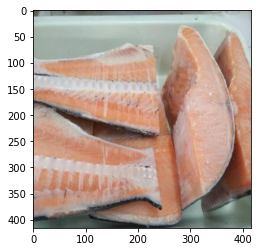

In [10]:
img_sample = cv2.cvtColor(x_train[1], cv2.COLOR_BGR2RGB )
plt.imshow(img_sample)
print(y_train[1])
x_train.shape

In [11]:
# Data augmentation
aug = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True, 
        fill_mode="nearest")

# Create model

In [12]:
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', 
                                             include_top = False, input_shape = (416,416,3))
for layer in base_model.layers:
  layer.trainable = False

2022-08-24 09:56:46.547817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:56:46.548781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:56:46.549652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:56:46.550621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 09:56:46.551385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

234708992/234698864 [==============================] - 4s 0us/step


In [13]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(100, activation='relu')(x)
predictions = layers.Dense(1, activation = 'sigmoid')(x)

In [14]:
BS = 32
EPOCHS = 50
INIT_LR = 1e-3
lr_schedule = LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optimizer = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [15]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=optimizer, loss=losses.binary_crossentropy, metrics=['accuracy'])

# Training

In [16]:
history = head_model.fit(
            aug.flow(x_train, y_train, batch_size=BS),
            validation_data=(x_validate, y_validate),
            epochs=EPOCHS,
            verbose=1,
            callbacks=[lr_schedule])

2022-08-24 09:56:56.199500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-24 09:57:06.683390: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 31s 2s/step - loss: 1.2785 - accuracy: 0.5016 - val_loss: 1.0104 - val_accuracy: 0.5278
Epoch 2/50
10/10 [==============================] - 14s 1s/step - loss: 1.3174 - accuracy: 0.5016 - val_loss: 0.9972 - val_accuracy: 0.5278
Epoch 3/50
10/10 [==============================] - 14s 1s/step - loss: 1.2523 - accuracy: 0.4921 - val_loss: 0.9838 - val_accuracy: 0.5278
Epoch 4/50
10/10 [==============================] - 14s 1s/step - loss: 1.2417 - accuracy: 0.5300 - val_loss: 0.9689 - val_accuracy: 0.5278
Epoch 5/50
10/10 [==============================] - 14s 1s/step - loss: 1.0556 - accuracy: 0.5552 - val_loss: 0.9540 - val_accuracy: 0.5556
Epoch 6/50
10/10 [==============================] - 14s 1s/step - loss: 1.1013 - accuracy: 0.5174 - val_loss: 0.9391 - val_accuracy: 0.5556
Epoch 7/50
10/10 [==============================] - 14s 1s/step - loss: 1.1535 - accuracy: 0.4858 - val_loss: 0.9234 - val_accuracy: 0.5278
Epoch 8/50
10/10 [=============

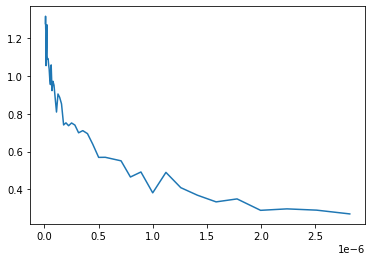

In [17]:
# plot the training results to see the loss against LR
lrs = 1e-8 * 10**(np.arange(EPOCHS)/20)
plt.plot(lrs, history.history["loss"])

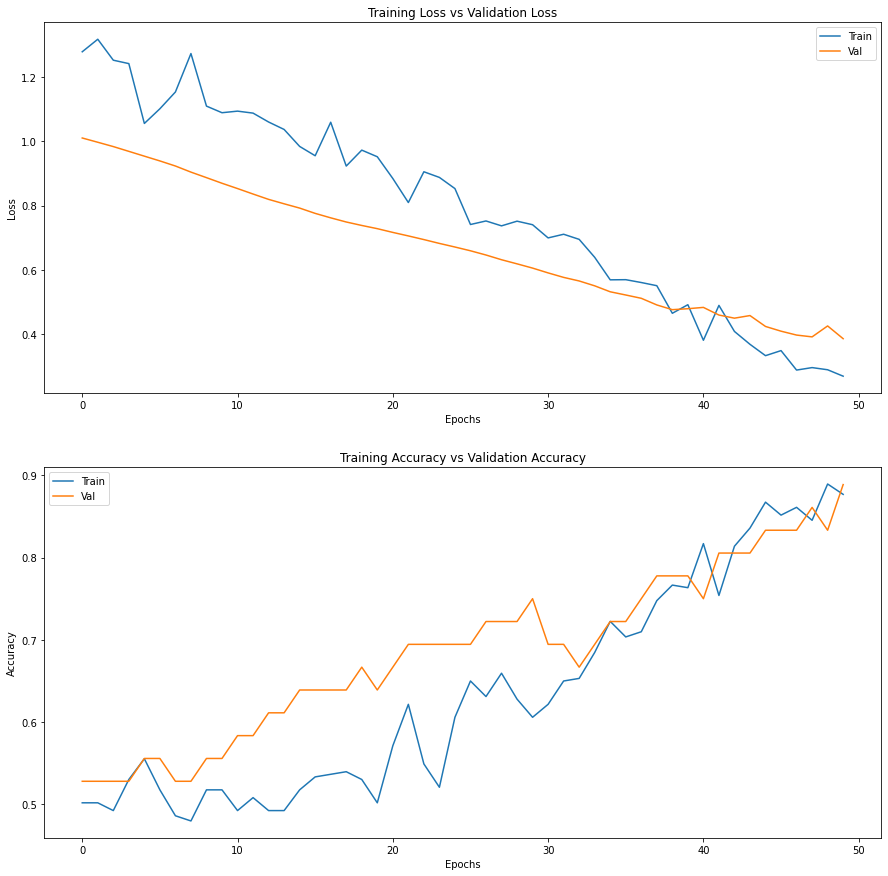

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [19]:
print("[INFO] Calculating model accuracy")
train_scores = head_model.evaluate(x_train, y_train)
test_scores = head_model.evaluate(x_test, y_test)
#all_scores = head_model.evaluate(np_image_list, image_labels)
print(f"Test Accuracy (on train dataset): {train_scores[1]*100}")
print(f"Test Accuracy (on test dataset): {test_scores[1]*100}")
#print(f"Test Accuracy (on all dataset): {all_scores[1]*100}")

[INFO] Calculating model accuracy
12/12 [==============================] - 4s 368ms/step - loss: 0.1825 - accuracy: 0.9462
Test Accuracy (on train dataset): 95.26813626289368
Test Accuracy (on test dataset): 94.61756348609924


Actual is wild and Prediction is wild:  167
Actual is wild and Prediction is farm:  9
Actual is farm and Prediction is wild:  10
Actual is farm and Prediction is farm:  167
Total Correct Prediction: 334 / 353


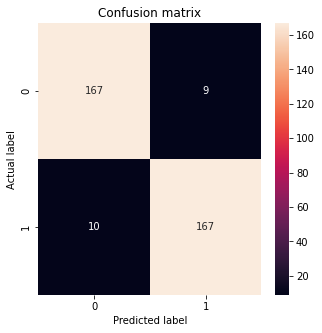

In [20]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Actual is wild and Prediction is wild: ', cm[0][0])
    print(f'Actual is wild and Prediction is farm: ', cm[0][1])
    print(f'Actual is farm and Prediction is wild: ', cm[1][0])
    print(f'Actual is farm and Prediction is farm: ', cm[1][1])
    print(f'Total Correct Prediction: {np.sum(cm[0][0] + cm[1][1])} / {np.sum(cm)}')
    

test_predictions_baseline = head_model.predict(x_test, batch_size=BS)

plot_cm(y_test, test_predictions_baseline)